In [0]:
import random, string
password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))

#Download ngrok
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip
#Setup sshd
! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
#Set root password
! echo root:$password | chpasswd
! mkdir -p /var/run/sshd
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc
! echo "export LD_LIBRARY_PATH" >> /root/.bashrc

#Run sshd
get_ipython().system_raw('/usr/sbin/sshd -D &')

#Ask token
print("Copy authtoken from https://dashboard.ngrok.com/auth")
import getpass
authtoken = getpass.getpass()

#Create tunnel
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')
#Print root password
print("Root password: {}".format(password))
#Get public address
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import required libraries
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
from scipy.sparse.linalg import svds
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

# Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics) - 5





In [2]:
#Data Import
#Read and explore the dataset. ( Rename column, plot histograms, find data characteristics)
#Import the data set
df = pd.read_csv('/content/drive/My Drive/PGP-AIML-UT-Austin-Jun19/Recommendation Systems/Project/ratings_Electronics.csv')#, header=None)
df.head()

,USERID,PRODUCTID,RATING,TIMESTAMP
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [0]:
df.columns = ['USERID', 'PRODUCTID', 'RATING', 'TIMESTAMP']
df.to_csv("/content/drive/My Drive/PGP-AIML-UT-Austin-Jun19/Recommendation Systems/Project/ratings_Electronics.csv", index=False)

In [4]:
df.head()

,USERID,PRODUCTID,RATING,TIMESTAMP
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [0]:
df.drop(['TIMESTAMP'],axis=1,inplace=True)

In [6]:
df.head()

,USERID,PRODUCTID,RATING
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [7]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824481
No of columns:  3


In [8]:
#Check Data types
df.dtypes

USERID        object
PRODUCTID     object
RATING       float64
dtype: object

In [9]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 USERID       0
PRODUCTID    0
RATING       0
dtype: int64


In [10]:
# Summary statistics of 'rating' variable
df['RATING'].describe().transpose()

count    7.824481e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: RATING, dtype: float64

In [11]:
# find minimum and maximum ratings
print('The minimum rating is: %d' %(df['RATING'].min()))
print('The maximum rating is: %d' %(df['RATING'].max()))

The minimum rating is: 1
The maximum rating is: 5


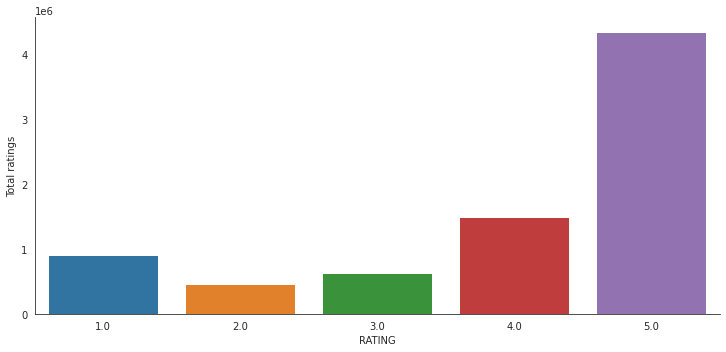

In [12]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("RATING", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total ratings") 

In [13]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['USERID'].nunique())
print('Number of unique ITEMS in Raw data = ', df['PRODUCTID'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476001


In [14]:
# Top 20 users
most_rated = df.groupby('USERID').size().sort_values(ascending=False)[:20]
most_rated

USERID
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A3EXWV8FNSSFL6    282
A38RMU1Y5TDP9     282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
dtype: int64

# Take a subset of the dataset to make it less sparse/ denser. (For example, keep the users only who has given 50 or more number of ratings.) - 10 

In [15]:
counts = df['USERID'].value_counts()
df_final = df[df['USERID'].isin(counts[counts >= 50].index)]
print(df_final)
# df_final.head()

                 USERID   PRODUCTID  RATING
93       A3BY5KCNQZXV5U  0594451647     5.0
117       AT09WGFUM934H  0594481813     3.0
176      A32HSNCNPRUMTR  0970407998     1.0
177      A17HMM1M7T9PJ1  0970407998     4.0
491      A3CLWR1UUZT6TG  0972683275     5.0
...                 ...         ...     ...
7824425   A1E1LEVQ9VQNK  B00LGQ6HL8     5.0
7824426  A2NYK9KWFMJV4Y  B00LGQ6HL8     5.0
7824435  A3AYSYSLHU26U9  B00LI4ZZO8     4.0
7824437  A2NYK9KWFMJV4Y  B00LI4ZZO8     5.0
7824443  A2BYV7S1QP2YIG  B00LKG1MC8     5.0

[125871 rows x 3 columns]


In [16]:
print('Number of unique USERS in final data = ', df_final['USERID'].nunique())
print('Number of unique ITEMS in final data = ', df_final['USERID'].nunique())

Number of unique USERS in final data =  1540
Number of unique ITEMS in final data =  1540


In [17]:
final_ratings_matrix = df_final.pivot(index = 'USERID', columns ='PRODUCTID', values = 'RATING').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [18]:
final_ratings_matrix.head()

PRODUCTID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
USERID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

USERID,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,A10Y058K7B96C6,A10ZBR6O8S8OCY,A10ZFE6YE0UHW8,A110PC8C5Y7MQD,A110VKXAVLAYKY,A111WCUF5KA2I6,A1143YEAZYMYHJ,A11D1KHM7DVOQK,A11ED8O95W2103,A11EXFO14WEJM1,A11EYMH9UV9XG7,A11FX8HL2ANK6T,A11I1I9QLMAM1A,A11IXJ8M1JO296,A11KQADBYE0UZL,A11KZ906QD08C5,A11LNPG39A2ZV4,A11OTLEDSW8ZXD,A11P105WVK5240,A11R5VW7IM6ISQ,A11T807LX2EF00,A11ULAZ4B5ZXC8,A11YIHB6IW352W,A11YOTONCPRQ9S,A124WZCUIH2T7W,A12ANFNOSMW5VD,A12DLJESJKM1OQ,A12DQZKRKTNF5E,A12EVK82QUTSA6,A12LH2100CKQO,...,AW6FQE5QRF2LM,AW6J9IILGOZY3,AWH2AY17ZU7W2,AWHL379EE14K7,AWJWCKB92RJX2,AWNBZSEZ9P8BE,AWNJAY0M5UI70,AWPN47SSWK1JV,AWPODHOB4GFWL,AWSK1ZAEU1KFL,AWZR0O65DL2Q,AX05DBU8IRUWY,AX7317G153T8W,AXP8GO5Q3AXSA,AXR3CV6A4FMBG,AXU3VKZE848IY,AXU8RH1DEV21H,AXYM52DNK6NDF,AY3D7DG5L5WCK,AY3XPKRAMKKY7,AY4EXFOO43C3S,AY6A8KPYCE6B0,AYB4ELCS5AM8P,AYCAIHABPYWVJ,AYGEKID3G7DPW,AYLLSFYS3UP1H,AYMD77ITD15PT,AYNAH993VDECT,AYO1146CBIV5C,AYOMAHLWRQHUG,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
PRODUCTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Split the data randomly into train and test dataset. (For example, split it in 70/30 ratio) 4. Build Popularity Recommender model. - 10 

In [20]:
#Split the data randomnly into test and train datasets
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)
train_data.head()

,USERID,PRODUCTID,RATING
6595852,A2BYV7S1QP2YIG,B009EAHVTA,5.0
4738240,AB094YABX21WQ,B0056XCEAA,1.0
4175595,A3D0UM4ZD2CMAW,B004I763AW,5.0
3753015,AATWFX0ZZSE6C,B0040NPHMO,3.0
1734766,A1NNMOD9H36Q8E,B0015VW3BM,4.0


In [21]:
train_data.shape
test_data.shape

(88109, 3)

(37762, 3)

# Build Popularity Recommender model

In [22]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('PRODUCTID').agg({'USERID': 'count'}).reset_index()
train_data_grouped.rename(columns = {'USERID': 'SCORE'},inplace=True)
train_data_grouped.head()

,PRODUCTID,SCORE
0,0594451647,1
1,0594481813,1
2,0970407998,1
3,0972683275,3
4,1400501466,4


In [23]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['SCORE', 'PRODUCTID'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['RANK'] = train_data_sort['SCORE'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,PRODUCTID,SCORE,RANK
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


In [0]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['USERID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [25]:
find_recom = [15,121,53]   # This list is user choice.
for i in find_recom:
    print("Recommendation for the USERID: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Recommendation for the USERID: 15

       USERID   PRODUCTID  SCORE  RANK
30847      15  B0088CJT4U    133   1.0
30287      15  B007WTAJTO    124   2.0
19647      15  B003ES5ZUU    122   3.0
8752       15  B000N99BBC    114   4.0
30555      15  B00829THK0     97   5.0


Recommendation for the USERID: 121

       USERID   PRODUCTID  SCORE  RANK
30847     121  B0088CJT4U    133   1.0
30287     121  B007WTAJTO    124   2.0
19647     121  B003ES5ZUU    122   3.0
8752      121  B000N99BBC    114   4.0
30555     121  B00829THK0     97   5.0


Recommendation for the USERID: 53

       USERID   PRODUCTID  SCORE  RANK
30847      53  B0088CJT4U    133   1.0
30287      53  B007WTAJTO    124   2.0
19647      53  B003ES5ZUU    122   3.0
8752       53  B000N99BBC    114   4.0
30555      53  B00829THK0     97   5.0




# Build Collaborative Filtering model. - 10

In [26]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,USERID,PRODUCTID,RATING
0,6595852,A2BYV7S1QP2YIG,B009EAHVTA,5.0
1,4738240,AB094YABX21WQ,B0056XCEAA,1.0
2,4175595,A3D0UM4ZD2CMAW,B004I763AW,5.0
3,3753015,AATWFX0ZZSE6C,B0040NPHMO,3.0
4,1734766,A1NNMOD9H36Q8E,B0015VW3BM,4.0


In [27]:
#User-based Collaborative Filtering
pivot_df = df_CF.pivot(index = 'USERID', columns ='PRODUCTID', values = 'RATING').fillna(0)
pivot_df.shape
pivot_df.head()

(1540, 48190)

PRODUCTID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
USERID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

PRODUCTID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
USERID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [29]:
pivot_df.set_index(['user_index'], inplace=True)
pivot_df.head()

PRODUCTID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.) - 10 


In [0]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [31]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

PRODUCTID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,0.002740,0.005144,0.007609,0.006248,0.002238,0.001380,0.007490,0.006603,-0.002774,-0.000611,0.005742,0.003352,0.006948,0.033771,0.050016,0.000428,0.007371,0.003793,0.002188,0.029240,0.001328,0.002442,0.000597,0.001121,0.000998,0.000971,0.002601,0.000362,0.003866,0.002477,...,0.004195,0.013884,0.029770,0.009769,0.000328,1.786030e-02,0.214161,0.012370,-0.007345,0.001119,0.097072,0.059136,0.007721,0.053163,0.070980,-0.002634,0.001039,0.015014,0.160980,1.786030e-02,0.038927,0.111473,-0.001243,0.280426,0.233076,0.228136,0.031142,0.301215,-0.001294,-0.001795,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,0.011586,0.005878,0.013008,0.004533,0.000138,0.000710,0.012295,0.002374,0.003437,0.004322,0.003412,0.001510,0.003783,0.005507,0.016031,0.000684,0.004313,0.002023,0.004701,0.027990,-0.000307,0.000941,0.000192,0.000031,0.000703,0.000968,0.004060,-0.000222,0.002816,0.000823,...,0.016443,0.001595,0.019103,0.003627,-0.000063,9.059451e-03,0.001982,-0.002046,0.014991,0.008442,-0.015009,-0.023460,0.006261,-0.003664,0.023399,0.005163,0.000143,0.003696,-0.000358,9.059451e-03,-0.013860,0.024497,0.010264,0.018962,0.010708,0.012312,-0.011088,0.138789,0.005661,0.028307,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,0.010652,-0.001785,0.003712,-0.003400,-0.001470,-0.000858,0.003583,-0.006089,0.011940,0.012993,-0.003396,-0.001812,-0.004454,0.014428,-0.009288,-0.000064,-0.004780,-0.002592,-0.000178,-0.004091,-0.001010,-0.002195,-0.000425,-0.000617,-0.000531,-0.000415,0.001746,0.000361,-0.002415,-0.001121,...,0.002614,0.020184,0.006436,-0.006516,-0.000314,-4.245947e-03,-0.014910,0.004824,0.054930,0.004780,-0.014461,0.005226,0.008377,0.030376,0.022412,0.027762,-0.000435,-0.004525,0.001284,-4.245947e-03,-0.016335,-0.021634,0.009076,0.006990,-0.025551,-0.006922,-0.013068,0.050088,0.016156,0.026709,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,0.001405,0.006250,0.006382,0.007611,0.001493,0.001514,0.005035,0.007532,-0.001492,0.003372,0.004802,0.002732,0.005770,-0.004952,0.009293,0.000490,0.006350,0.003464,0.002064,0.024304,0.001529,0.002537,0.000518,0.000760,0.000549,0.000974,0.001333,-0.000058,0.002827,0.001547,...,0.009978,-0.004203,0.001358,0.011285,0.000290,1.072706e-03,-0.006264,-0.004407,-0.005160,0.000752,0.004034,0.009716,-0.003497,-0.018021,-0.008387,-0.002492,0.000454,0.003276,0.009347,1.072706e-03,-0.003291,0.018267,-0.001003,-0.008367,-0.000026,-0.007925,-0.002632,0.022344,-0.001748,-0.005637,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.0

In [0]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [46]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 400
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 400):

                   user_ratings  user_predictions
Recommended Items                                
B000N99BBC                  0.0          1.369806
B0088CJT4U                  0.0          1.357358
B002V88HFE                  0.0          1.090390
B00829THK0                  0.0          1.080537
B001TH7GUU                  0.0          1.065383


In [47]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['AVG_ACTUAL_RATINGS', 'AVG_REDICTED_RATINGS']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,AVG_ACTUAL_RATINGS,AVG_REDICTED_RATINGS,item_index
PRODUCTID,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [49]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 200
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 200):

                   user_ratings  user_predictions
Recommended Items                                
B0079UAT0A                  0.0          1.321825
B004CLYEFK                  0.0          1.044018
B007WTAJTO                  0.0          0.999079
B008ULPE70                  0.0          0.962866
B008X9Z528                  0.0          0.945024


In [50]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['AVG_ACTUAL_RATINGS', 'AVG_REDICTED_RATINGS']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,AVG_ACTUAL_RATINGS,AVG_REDICTED_RATINGS,item_index
PRODUCTID,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [48]:
RMSE = round((((rmse_df.AVG_ACTUAL_RATINGS - rmse_df.AVG_REDICTED_RATINGS) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



# Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products. - 5 


In [37]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 200
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 200):

                   user_ratings  user_predictions
Recommended Items                                
B0079UAT0A                  0.0          1.321825
B004CLYEFK                  0.0          1.044018
B007WTAJTO                  0.0          0.999079
B008ULPE70                  0.0          0.962866
B008X9Z528                  0.0          0.945024


In [51]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 400
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 400):

                   user_ratings  user_predictions
Recommended Items                                
B000N99BBC                  0.0          1.369806
B0088CJT4U                  0.0          1.357358
B002V88HFE                  0.0          1.090390
B00829THK0                  0.0          1.080537
B001TH7GUU                  0.0          1.065383


# Summarise your insights.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of 
the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may not be suitable to the user. One can see the differance for the user id 121 & 200. The Popularity based model has recommended the same set of 5 products, but Collaborative Filtering based model has recommended a completely different list based on the user's purchase history